In [2]:
import os
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties

# 獲取當前工作目錄
current_dir = os.getcwd()
version3_path = os.path.join(current_dir, "TrafficTDApython", "Version3", "tdamapper", "core_old.py")

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering

from utils.models import *
from utils.utils_v3 import *
from utils.plots import *

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [8]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    main_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = main_data[main_data['發生月份'] < 11]
    selected_data = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    split_death_injury_data = split_death_injury(selected_data['死亡受傷人數'])
    full_data = pd.concat([selected_data, split_death_injury_data], axis=1)

    # 補齊缺失值
    full_data[select_lst] = full_data[select_lst].fillna('未紀錄')

    # 速限範圍
    full_data = full_data[(full_data['速限-第1當事者'] < 200) &
                      (full_data['當事者事故發生時年齡'] < 100) &
                      (full_data['當事者事故發生時年齡'] > 0)]

    full_data.drop(columns=['死亡受傷人數'], inplace=True)
    
    # 篩選駕駛人的資料
    full_data = full_data[full_data['當事者行動狀態大類別名稱'] == '車的狀態']
    full_data.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
    # 篩選離群資料(影響MCA的因子得分)
    full_data = full_data[(full_data['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (full_data['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (full_data['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)') &
                  (full_data['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                    (full_data['車輛撞擊部位大類別名稱-最初'] != '未紀錄')]

    return full_data

full_dataA1 = preprocess(dataA1, select_lst)
full_dataA2 = preprocess(dataA2, select_lst)

# 下採樣資料
sampling_ratio = 0.33  # 下採樣比例，根據A1 和 A2 原始數據量比例調整
total_ratio = len(full_dataA1) / len(full_dataA2) # 保留 A1/A2 的比例
downsampled_A1, downsampled_A2 = downsample_by_month_simple(full_dataA1, full_dataA2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)
# 處理年齡和速限
rbind_data = process_age_speed(rbind_data)
rbind_data.drop(['死亡', '受傷'], axis=1, inplace=True)
# 唯一值處理
columns_to_drop = []
for column in rbind_data.columns:
    if rbind_data[column].nunique() == 1:  # 檢查唯一值數量是否等於 1
        columns_to_drop.append(column)
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)
print('dummy_data:', dummy_data.shape)
mapper_numpy = dummy_data.to_numpy()

# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']

44 10057
45 10286
40 9143
35 8000
36 8229
39 8914
47 10743
43 9829
40 9143
47 10743
dummy_data: (95503, 142)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

# Kmode

In [ ]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

cost = []
all_results = {}
K = range(1, 5)

for k in K:

    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

In [ ]:
# with open('Version3/Data/CarData/kmode_result.pickle', 'wb') as f:
#     pickle.dump(all_results, f)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [155]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

1    48690
0    46813
Name: count, dtype: int64


# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.122         3.00%                      3.00%
1              0.119         2.92%                      5.92%
2              0.089         2.19%                      8.11%
3              0.076         1.86%                      9.97%
4              0.075         1.84%                     11.82%
5              0.072         1.77%                     13.59%
6              0.067         1.63%                     15.22%


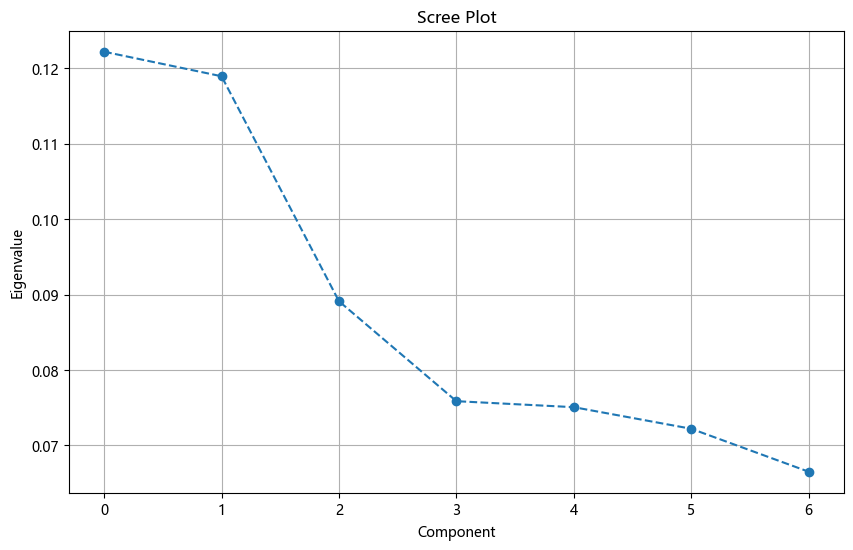

In [9]:
mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(dummy_data)
lens = mca.transform(dummy_data)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

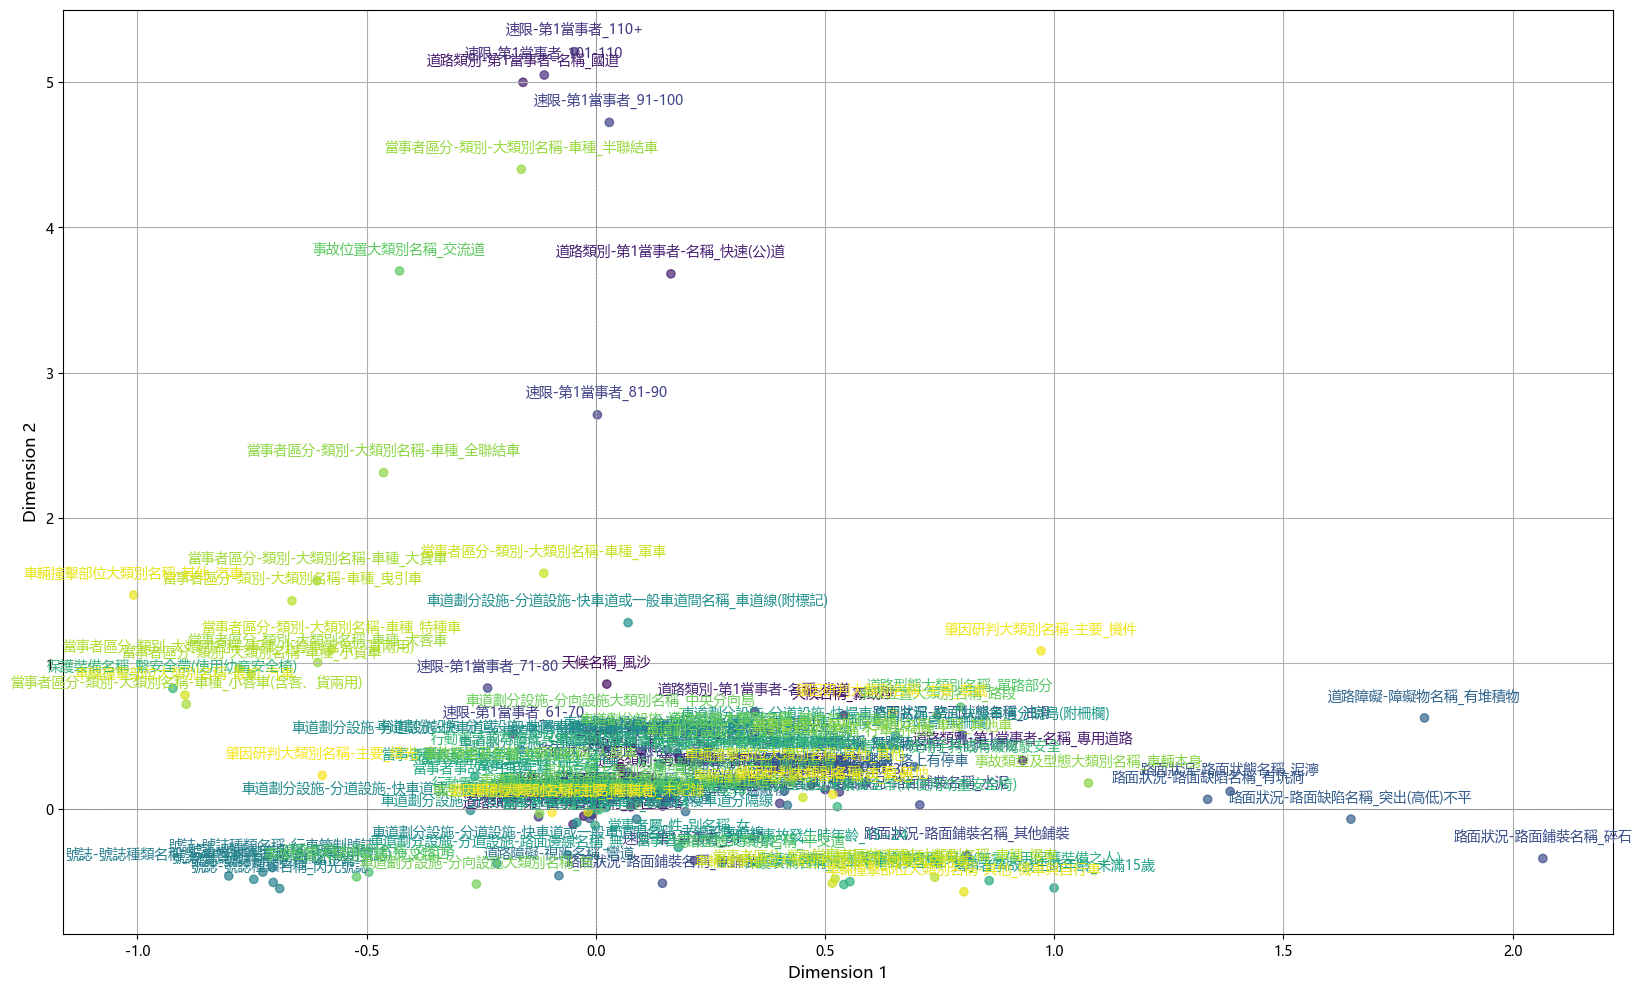

In [10]:
col_coordinate = mca.column_coordinates(dummy_data)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [12]:
Overlap = [2]
Interval = [11]

detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            # filename = f"./Gridsearch/Component7Car/results_o{overlap}i{interval}_new_noresemple.pkl"

            # with open(filename, 'wb') as file:
            #     pickle.dump(result, file)

            # print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue
        
detailed_results_df = pd.DataFrame(detailed_results)

overlap: 2, interval: 11


01/09/2025 06:36:46 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
01/09/2025 06:36:47 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
01/09/2025 06:36:49 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
01/09/2025 06:36:50 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
01/09/2025 06:36:50 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
01/09/2025 06:36:52 PM core WARNING: Unable to perform 

# 國科會模型為O2I11，seed為87，iter=150

In [6]:
with open('./GridSearch/Component7Car/results_o2i11_new.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

# 目前分析使用的模型

In [13]:
# read pickle
with open('./ModelPerformance/car_performance_svc.pkl', 'rb') as f:
    car_decision_scores = pickle.load(f)

sorted_indices = np.argsort(car_decision_scores['indices'])
y_decision_sorted = car_decision_scores['decision_scores'][sorted_indices]
rbind_data['score'] = y_decision_sorted

Seed: 87
Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


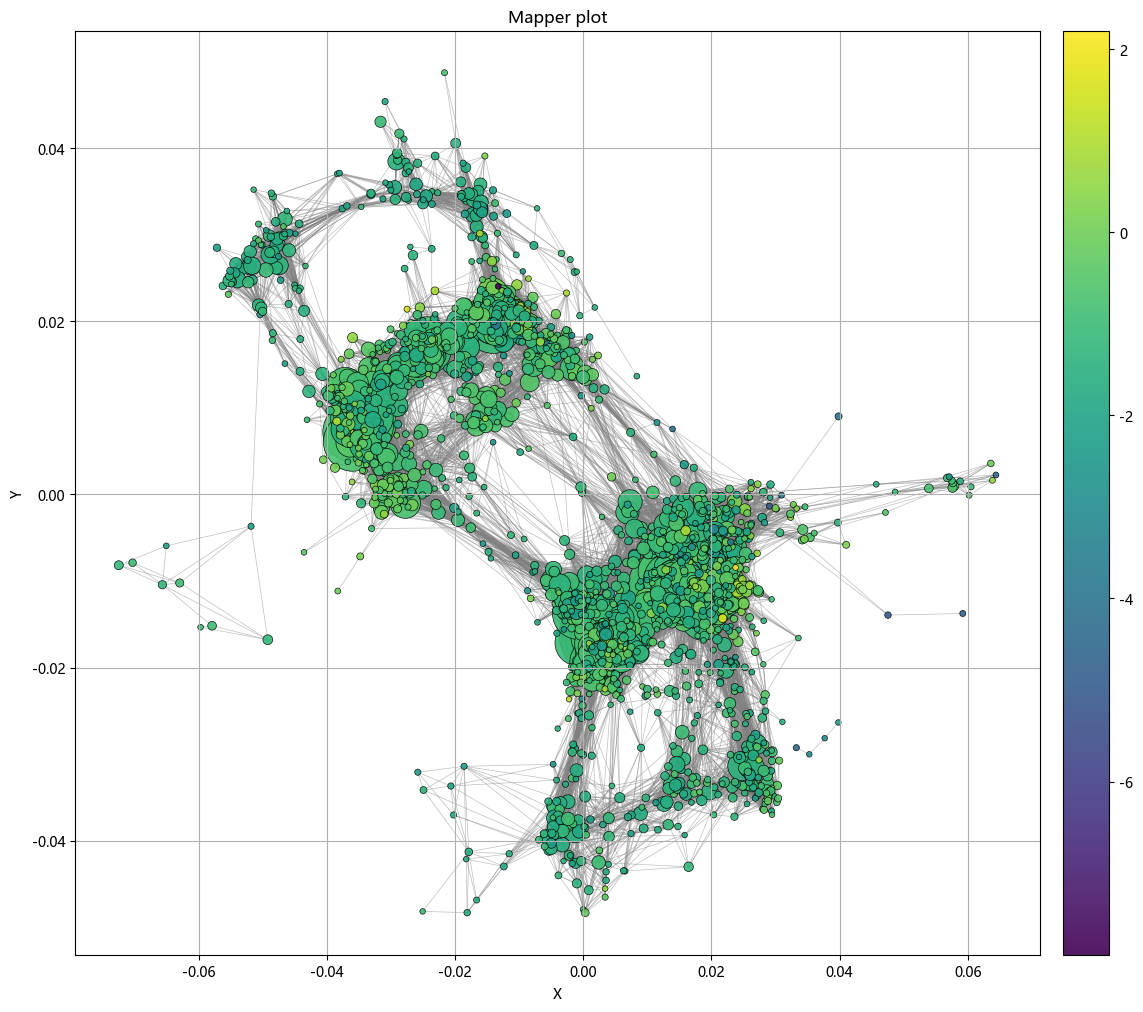

In [16]:
choose = 'score'

for i in range(87, 88):
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=150)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, average_encoded_label, avg=True)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=15, threshold=0, range_lst=[-0.2, 0.15, 0.06, -0.2])
    mapper_plotter.plot(choose, avg=True, set_label=True, size=100000)
    mapper_plotter.plot_3d_pvis(range_lst=[-0.2, 0.2, 0.2, -0.2])

In [ ]:
lst = ['Cluster', '車輛撞擊部位大類別名稱-最初', '當事者事故發生時年齡', '顯著特徵']
# lst = ['當事者事故發生時年齡']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=87, iterations=150)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=15, threshold=700, range_lst=[-0.2, 0.1, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i11_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
lst = ['發生月份', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃']
lst = ['肇因研判子類別名稱-個別']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=44, iterations=100)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.25, 0.25, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                            save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i14_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
choose = '事故位置大類別名稱'

for index in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=30, threshold=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")


# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.1, -0.03), (-0.1, 0),(-0.07, 0.1), (0, 0.06), (0.02, 0.04), (-0.06, 0.01)])
rectangle2 = Polygon([(-0.04, -0.02), (-0.06, 0.01), (0.02, 0.04), (0.02, 0.02)])
rectangle3 = Polygon([(-0.04, -0.03), (-0.04, -0.02),(0.02, 0.02), (0.05, 0.05), (0.15, 0), (0.07, -0.02)])
rectangle4 = Polygon([(-0.065, -0.1), (-0.04, -0.03), (0.07, -0.02), (0.1, -0.1)])

# filtered_full_info = full_info[(full_info['y'] > -0.2) &
#                                (full_info['y'] < 0.1) &
#                                (full_info['x'] > -0.1) &
#                                (full_info['x'] < 0.15)]
# filtered_full_info = filtered_full_info[filtered_full_info['size'] > 15]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

模型順序
由於1，2群體在拓樸中有過渡的性質，且是從號誌到無號誌，死亡的分布有增加的趨勢，所以使用羅吉斯 <br/>
3，4群體是從這兩個群體的雨天分割出來的，在分布上可看出較類似於不同群體，因為邊的連接較少，所以使用SVM <br/>
5、6群體是離群值以及覆蓋值，分別是群體間的不相似、相似特徵，認為在空間分布上也是類似於分群，所以使用SVM

In [23]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 找出群體2和3的交集
intersection_21 = {idx for idx in count_2 if idx in count_1}

# 從交集中移除屬於群體2和3交集的資料
intersection_indexes -= intersection_21

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes and i not in intersection_21]
count_1 = [i for i in count_1 if i not in intersection_indexes and i not in intersection_21]
count_2 = [i for i in count_2 if i not in intersection_indexes and i not in intersection_21]
count_3 = [i for i in count_3 if i not in intersection_indexes and i not in intersection_21]
count_out = [i for i in count_out if i not in intersection_indexes and i not in intersection_21]

# 分群處理
full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
full_21 = dummy_data.loc[list(intersection_21)]
overlap_data = dummy_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]
assert len(intersection_21) == full_21.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + full_21.shape[0] + overlap_data.shape[0])
print(dummy_data.shape[0])


87488
95503


In [154]:
full_info.to_csv('/Data/CarData/full_info.csv', index=False)
full_0.to_csv('/Data/CarData/full_0.csv', index=False)
full_1.to_csv('/Data/CarData/full_1.csv', index=False)
full_2.to_csv('/Data/CarData/full_2.csv', index=False)
full_3.to_csv('/Data/CarData/full_3.csv', index=False)
full_out.to_csv('/Data/CarData/full_out.csv', index=False)
overlap_data.to_csv('/Data/CarData/overlap_data.csv', index=False)
full_21.to_csv('/Data/CarData/full_21.csv', index=False)

In [ ]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(full_21['死亡'].value_counts())
print(dummy_data['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

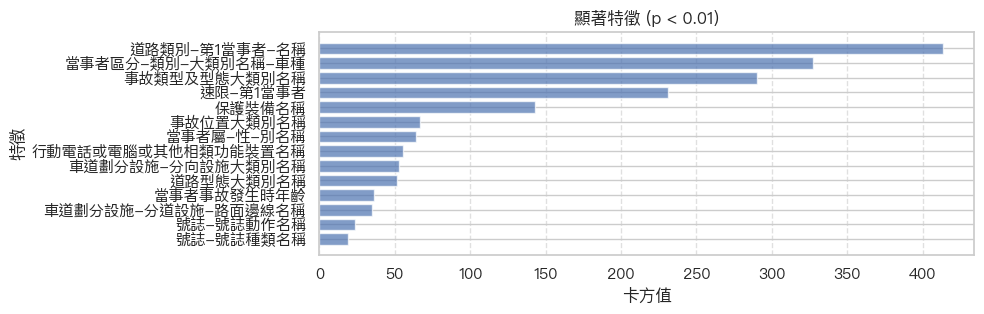

In [17]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [141]:
full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_2 = rbind_data.loc[count_2]
full_3 = rbind_data.loc[count_3]
full_21 = rbind_data.loc[list(intersection_21)]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0] + full_21.shape[0])
print(dummy_data.shape[0])

95503
95503


In [139]:
print(full_0.shape[0])
print(full_1.shape[0])
print(full_2.shape[0])
print(full_3.shape[0])
print(full_out.shape[0])
print(full_21.shape[0])
print(overlap_data.shape[0])

2920
30192
51981
4922
4094
292
1102


# 嚴重程度

In [144]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_21_s = get_severity(full_21)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [145]:
plot_column = '嚴重程度'

data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
嚴重程度,,,,,,,
Total,51981,4922,30192,2920,1102,292,4094
受傷1,31588,3547,26102,2595,843,231,2913
受傷1+,20177,1358,3970,315,256,57,1135
死亡,216,17,120,10,3,4,46


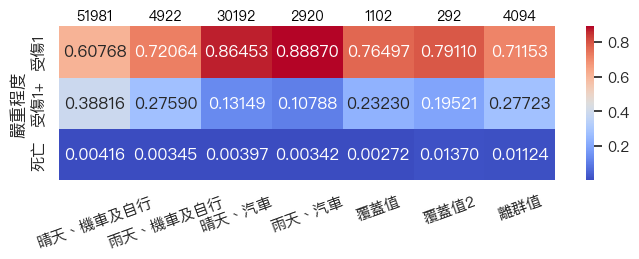

In [147]:
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".5f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()
